# k-nearest-Neighbour

## Load datasets

2024-12-13 14:59:16.094109: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2024-12-13 14:59:16.170131: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


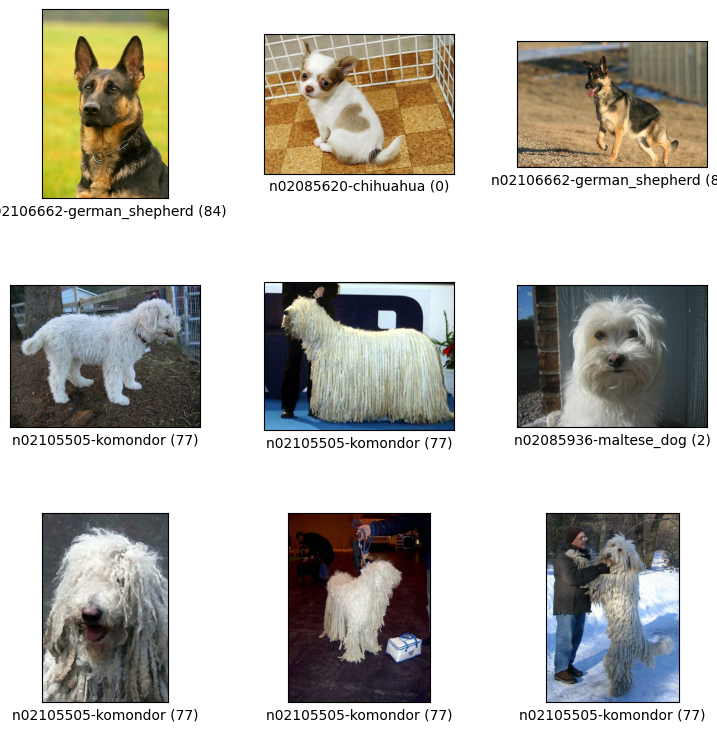

/var/folders/pb/8wrfvtz5593cjrgr_g89r70m0000gn/T/ipykernel_37448/1680334725.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
from pathlib import Path
import sys

notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent))

from setup import setup_dataset


train_dataset, test_dataset, metadata = setup_dataset('../dataset')

fig = tfds.show_examples(train_dataset, metadata)
fig.show()

## Merkmale
Die folgenden Merkmale wurden zur Merkmalsextraktion definiert:
https://gvpress.com/journals/IJMUE/vol8_no4/39.pdf

Farb-merkmale:
1. Helligkeit des Fells
2. Farbvarianz des Fells

Textur-merkmale:

3. Fellstruktur

Form-merkmale:

4. Form des Hunds auf dem Bild




Ideen:
- Histogramm
    - Maximaler Wert
    - Median
    - Mittelwert
    - Kurtosis
- Rechtecke
    - Anzahl der gefundenen Regionen
    - Avg(Höhe)/Avg(Breite)
    - Avg(Höhe)
    - Avg(Breite)

- 



[12334 31383 38246 40271 52551 75560 90375 63434 65140 13682]
<class 'numpy.ndarray'>


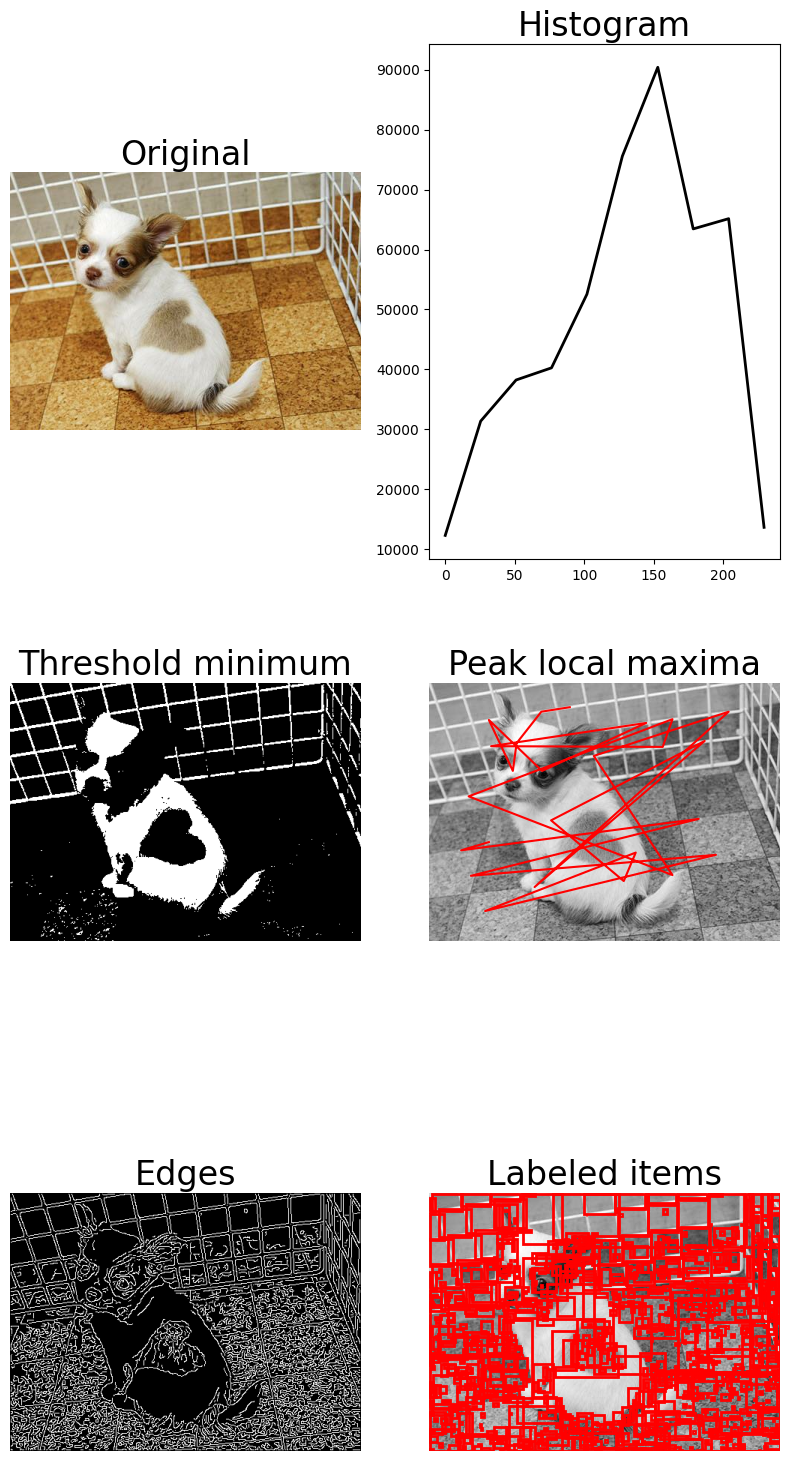

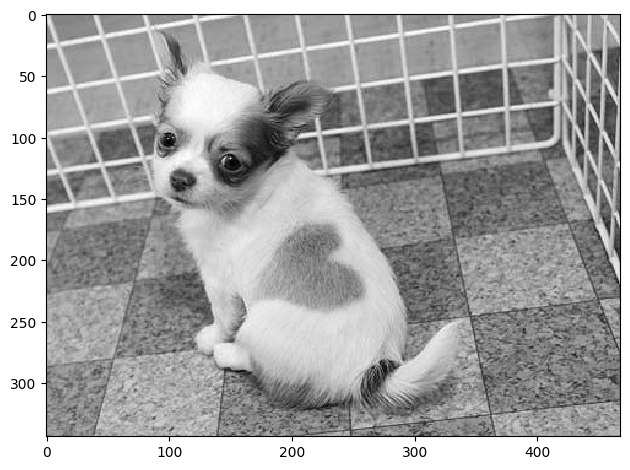

In [45]:
import cv2
import matplotlib.pyplot as plt
from skimage import filters, feature
from skimage.io import imshow
import numpy as np

"""for img, label in train_dataset:
    img_grayscale = tf.image.rgb_to_grayscale(img)
    img_np = img_grayscale.cpu().numpy()[:,:,0]
    img_canny = feature.canny(img_np)
    imshow(img_canny)"""

img = [element for element in train_dataset.take(5)][1][0]
img_grayscale = tf.image.rgb_to_grayscale(img)

img_np = img.numpy()
img_grayscale_np = img_grayscale.cpu().numpy()[:,:,0]


fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(8, 16))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flat


# Original anzeigen
ax0.imshow(img)
ax0.set_title("Original", fontsize=24)
ax0.axis("off")


# Histogram anzeigen
values, bins = np.histogram(img, bins=np.arange(256))
print(type(values))
ax1.plot(bins[:-1], values, lw=2, c="k")
ax1.set_title("Histogram", fontsize=24)
fig.set_tight_layout(tight=True)


# Divide Foreground and Background
from skimage.filters import threshold_minimum, try_all_threshold
threshold = threshold_minimum(img_grayscale_np, 95)
binary = img_grayscale > threshold
ax2.imshow(binary, cmap=plt.cm.gray)
ax2.set_title("Threshold minimum", fontsize=24)
ax2.axis("off")

# Maximum
from skimage.feature import peak_local_max
coordinates = peak_local_max(img_grayscale_np, min_distance=30)
ax3.imshow(img_grayscale_np, cmap=plt.cm.gray)
ax3.autoscale(False)
ax3.plot(coordinates[:,1],
         coordinates[:,0], c=(1.0,0.0,0.0))
ax3.set_title("Peak local maxima", fontsize=24)
ax3.axis("off")

# Canny filter
from skimage.feature import canny

edges = canny(img_grayscale_np)
ax4.imshow(edges, cmap=plt.cm.gray)
ax4.set_title("Edges", fontsize=24)
ax4.axis("off")

# image labeling
from skimage.measure import regionprops
import matplotlib.patches as mpatches
from skimage.morphology import label

label_image = label(edges)

ax5.imshow(img_grayscale_np, cmap=plt.cm.gray)
ax5.set_title("Labeled items", fontsize=24)
ax5.axis("off")

for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    rect=mpatches.Rectangle((minc, minr),maxc-minc, maxr-minr, fill=False, edgecolor="red", linewidth=2)
    ax5.add_patch(rect)

plt.tight_layout()
plt.show()




img_grayscale = tf.image.rgb_to_grayscale(img)
img_np = img_grayscale.cpu().numpy()[:,:,0]
img_canny = feature.canny(img_np)
imshow(img_np)

# Creating feature vector

In [ ]:
import scipy.stats as ss
from skimage.measure import regionprops_table
import matplotlib.patches as mpatches
from skimage.morphology import label
from skimage.feature import canny
import pandas as pd

def computeHistogrammFeatures(img):
    values, _ = np.histogram(img, bins=np.arange(256))
    nobs, minmax, mean, variance, skewness, kurtosis = ss.describe(values)
    return mean, skewness, kurtosis


def computeObjectFeatures(img):
    edges = canny(img_grayscale_np)
    label_image = label(edges)
    regions = regionprops(label_image)
    region = regions[0]
    for attribute in region:
       print(f"{attribute}: {region[attribute]}")
    print(regions[0])
    regions = regionprops_table(label_image, properties=("bbox", "area_bbox", "axis_major_length", "axis_minor_length", "orientation", "solidity"))
    df = pd.DataFrame(regions)
    df["bbox_height_width_ratio"] = (df["bbox-3"]-df["bbox-1"])/(df["bbox-2"]-df["bbox-0"])
    df["axis_ratio"] = (df["axis_major_length"])/(df["axis_minor_length"])
    df = df.drop(columns=["bbox-0","bbox-1", "bbox-2", "bbox-3"])
    df = df.describe()

    # todo: return relevant statistical numbers


    return df
    print(df)
    print(regions)
    num_regions = len(regions)
    region = regions[0]
    print(type(regions))
    for attribute in region:
       print(f"{attribute}: {region[attribute]}")




# TODO: compute more attributes of feature vector, then create feature vector -> reduction, selection etc.




    #for region in regionprops(label_image):
    #    minr, minc, maxr, maxc = region.bbox
    #    rect=mpatches.Rectangle((minc, minr),maxc-minc, maxr-minr, fill=False, edgecolor="red", linewidth=2)
    #    ax5.add_patch(rect)


computeObjectFeatures(img)

area: 74.0
area_bbox: 880.0
area_convex: 719.0
area_filled: 74.0
axis_major_length: 56.83338093865308
axis_minor_length: 25.228199759212103
bbox: (1, 3, 23, 43)
centroid: (14.45945945945946, 22.56756756756757)
centroid_local: [13.45945946 19.56756757]
coords: [[ 1  3]
 [ 1 38]
 [ 2  3]
 [ 2 38]
 [ 3  4]
 [ 3 39]
 [ 4  4]
 [ 4 39]
 [ 5  4]
 [ 5 39]
 [ 6  5]
 [ 6 40]
 [ 7  5]
 [ 7 40]
 [ 8  5]
 [ 8  6]
 [ 8 40]
 [ 9  6]
 [ 9 41]
 [10  6]
 [10 41]
 [11  6]
 [11 41]
 [12  7]
 [12 42]
 [13  7]
 [13 42]
 [14  7]
 [14  8]
 [14 42]
 [15  8]
 [15 42]
 [16  8]
 [16 42]
 [17  8]
 [17  9]
 [17 38]
 [17 39]
 [17 40]
 [17 41]
 [17 42]
 [18  9]
 [18 32]
 [18 33]
 [18 34]
 [18 35]
 [18 36]
 [18 37]
 [19  9]
 [19 27]
 [19 28]
 [19 29]
 [19 30]
 [19 31]
 [20  9]
 [20 10]
 [20 21]
 [20 22]
 [20 23]
 [20 24]
 [20 25]
 [20 26]
 [21 10]
 [21 15]
 [21 16]
 [21 17]
 [21 18]
 [21 19]
 [21 20]
 [22 10]
 [22 11]
 [22 12]
 [22 13]
 [22 14]]
eccentricity: 0.8960775336556677
equivalent_diameter_area: 9.706684619910

/Users/jannisgehring/VSCode/ml-lecture/.venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,area_bbox,axis_major_length,axis_minor_length,orientation,solidity,bbox_height_width_ratio,axis_ratio
count,936.00000,936.000000,936.000000,936.000000,936.000000,936.000000,867.000000
mean,299.29594,16.609964,6.464198,-0.079898,0.603900,1.564091,inf
std,1627.66997,20.580232,11.773897,1.036919,0.274483,1.323399,NaN
min,1.00000,0.000000,0.000000,-1.569618,0.054866,0.043478,1.000000
25%,8.00000,4.596634,1.208200,-1.005339,0.382003,0.796970,1.971388
50%,35.00000,9.546116,2.886180,-0.188710,0.583333,1.128289,3.410369
75%,150.00000,19.702479,6.536089,0.843606,0.808333,2.000000,6.278221
max,42160.00000,251.999380,160.973748,1.570796,1.000000,13.000000,inf
